### Import Python modules

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model      import LinearRegression
from sklearn.neural_network    import MLPRegressor
from sklearn.metrics           import r2_score, mean_squared_error

plt.style.use('ggplot')
%matplotlib inline
plt.rcParams['figure.figsize'] = [12, 10]

## Data Preparation

### Reading data

In this notebook, the COVID-19 data in New South Wales, Australia and the public transport usage of particular areas in Sydney are used to create predictive models.

In [2]:
covid_df = pd.read_csv('data/covid_nsw_data.csv', parse_dates=['notification_date'])
opal_df = pd.read_csv('data/opal_patronage_data.csv', parse_dates=['trip_origin_date'])

### Cleaning the data

The default column names are not descriptive so new column names are defined.

In [3]:
# Changing header names for dataframes
covid_headers = ['date', 'postcode', 'source', 'health_district', 'health_district_name', 'local_gov_code', 'local_gov_name']
opal_headers = ['date', 'mode_type', 'region', 'tap_hour', 'tap_on', 'tap_off']

covid_df.columns = covid_headers
opal_df.columns = opal_headers

Only some of the columns are necessary as the others are identifying codes. The date column can be set as an index. Some values for the tap data are '<50' which will be converted. These columns will be converted to numerical data.

In [4]:
#take columns that are needed and update dataframes
covid_df = covid_df[['date', 'postcode', 'source', 'health_district_name', 'local_gov_name']]
opal_df = opal_df[['date', 'mode_type', 'region','tap_on', 'tap_off']]

In [5]:
#set index
covid_df.set_index('date', inplace=True)
opal_df.set_index('date', inplace=True)

In [6]:
#sets values
opal_df.tap_on = opal_df.tap_on.str.replace(r'\D','').astype(int)
opal_df.tap_off = opal_df.tap_off.str.replace(r'\D','').astype(int)

For this analysis, only 6 regions are used - Chatswood, Macquarie Park, Parramatta, Strathfield, Sydney CBD and North Sydney. Other regions will be dropped.

In [7]:
#drop all rows that contain information on stations that are not needed
opal_df = opal_df[opal_df.region.isin(['Chatswood', 'Macquarie Park', 'North Sydney',  'Parramatta', 'Strathfield','Sydney CBD'])]
opal_df.reset_index(inplace=True)

The analysis will be based on daily cases and daily transport usage so the data must be grouped by days.

In [8]:
#create opal dataframe that is grouped by day
grouped_opal = opal_df.groupby(['date', 'mode_type', 'region']).sum()
grouped_opal.reset_index(inplace=True)

COVID cases from local sources have a much greater effect on the sentiment towards using public transport than COVID cases from overseas sources which is likely to be in quarantine. A dataframe of COVID cases that are locally acquired or undetermined is used for analysis. This will also be grouped by days.

In [9]:
local_covid_df = covid_df[covid_df['source'] != 'Overseas']
local_covid_df.head()

,postcode,source,health_district_name,local_gov_name
date,,,,
2020-03-02,2073.0,Locally acquired - source not identified,Northern Sydney,Ku-ring-gai (A)
2020-03-02,2077.0,Locally acquired - contact of a confirmed case...,Northern Sydney,Hornsby (A)
2020-03-03,2122.0,Locally acquired - contact of a confirmed case...,Northern Sydney,Ryde (C)
2020-03-04,2113.0,Locally acquired - contact of a confirmed case...,Northern Sydney,Ryde (C)
2020-03-04,2042.0,Locally acquired - contact of a confirmed case...,Sydney,Sydney (C)


In [10]:
local_covid_df = local_covid_df.groupby(['date']).size()
local_covid_df

date
2020-03-02    2
2020-03-03    1
2020-03-04    4
2020-03-05    2
2020-03-06    6
             ..
2020-10-16    5
2020-10-17    1
2020-10-19    3
2020-10-20    1
2020-10-21    1
Length: 167, dtype: int64

In [11]:
covid_tally = covid_df.groupby(['date']).size()
covid_tally

date
2020-01-25     3
2020-01-27     1
2020-03-01     2
2020-03-02     3
2020-03-03     6
              ..
2020-10-17     6
2020-10-18     6
2020-10-19    10
2020-10-20     4
2020-10-21     5
Length: 226, dtype: int64

In [12]:
idx = pd.date_range('01-01-2020', '10-21-2020')
covid_tally = covid_tally.reindex(idx, fill_value=0)
local_covid_df = local_covid_df.reindex(idx, fill_value=0)

In [13]:
covid_tally = pd.DataFrame({'tally': covid_tally, 'local_tally': local_covid_df})
covid_tally

,tally,local_tally
2020-01-01,0,0
2020-01-02,0,0
2020-01-03,0,0
2020-01-04,0,0
2020-01-05,0,0
...,...,...
2020-10-17,6,1
2020-10-18,6,0
2020-10-19,10,3
2020-10-20,4,1


In [14]:
merged_df = pd.merge(grouped_opal, covid_tally, left_on = 'date', right_index=True)
merged_df.rename(columns={'tally':'total_case_count'}, inplace=True)
merged_df = merged_df.groupby(['date', 'region']).sum()

Text(0.5, 1.0, 'Tap On Count by Region')

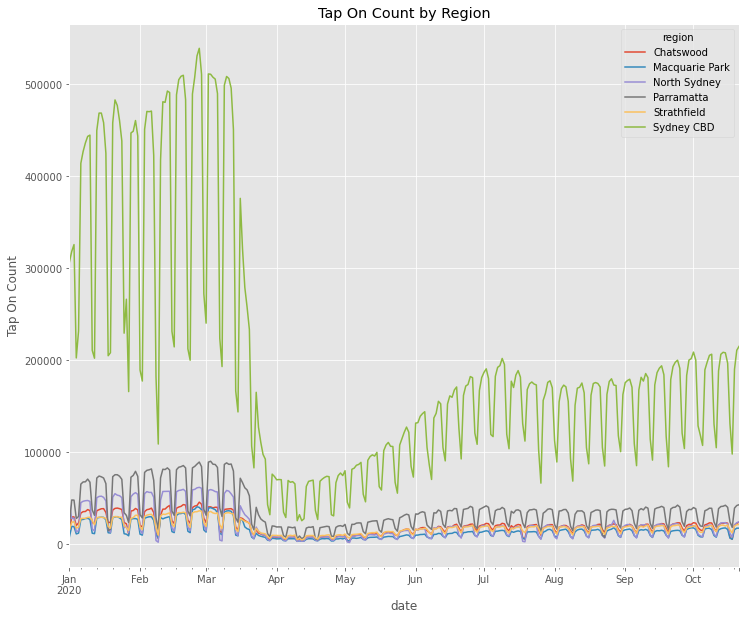

In [15]:
merged_df['tap_on'].unstack().plot()
plt.ylabel('Tap On Count')
plt.title('Tap On Count by Region')

We can see that there are weekly cycles for tap on usage which is expected as commuters during the week for work may not commute on the weekends. To remove these cycles, a rolling 14 day average will be used. This also helps eliminate noise.

Text(0.5, 1.0, '14 Day Average Tap On Count by Region')

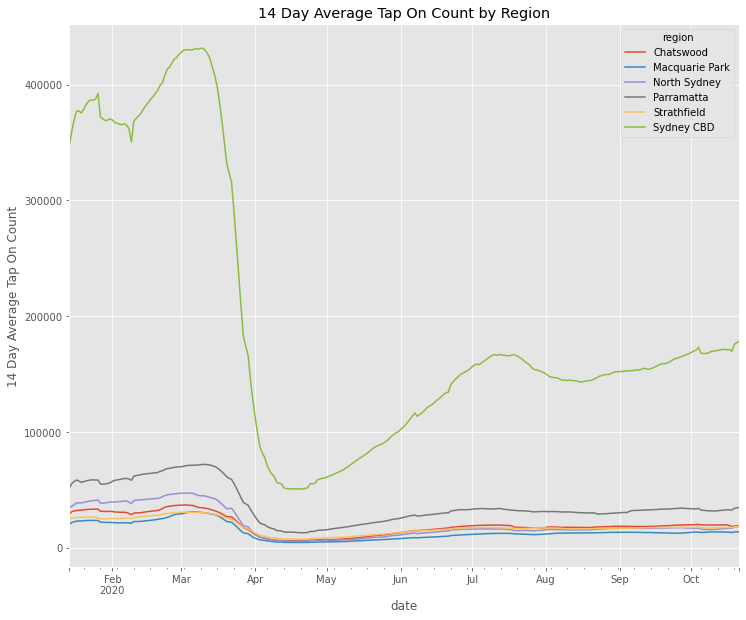

In [16]:
merged_df['tap_on'].unstack().rolling(window=14).mean().dropna().plot()
plt.ylabel('14 Day Average Tap On Count')
plt.title('14 Day Average Tap On Count by Region')

We can overlay the 14 day average of COVID cases reported to see if there is a relationship between taps on the Opal transport network and COVID cases reported.

Text(0.5, 1.0, '14 Day Average of Tap On and COVID Cases')

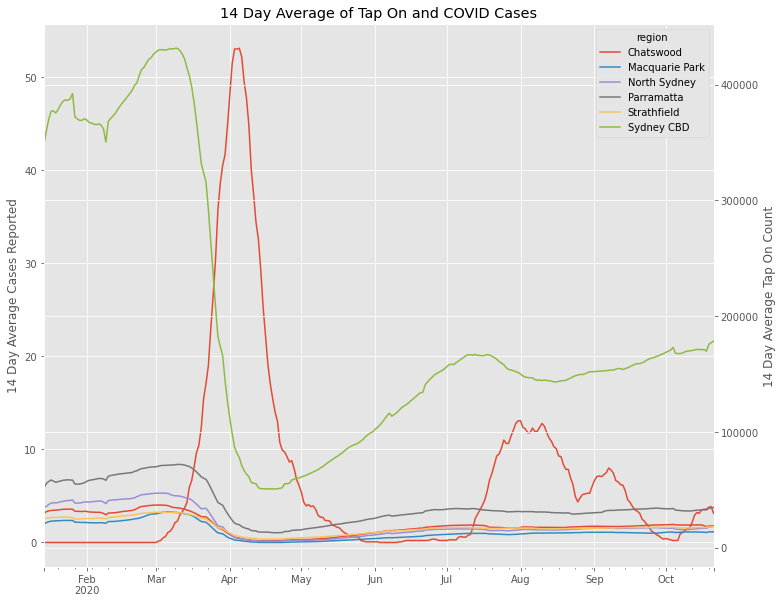

In [17]:
fig, ax1 = plt.subplots()
ax2 = ax1.twinx()

merged_df['tap_on'].unstack().rolling(window=14).mean().dropna().plot(ax=ax2)
local_covid_df.rolling(window=14).mean().dropna().plot(ax=ax1)

ax2.set_ylabel('14 Day Average Tap On Count')
ax1.set_ylabel('14 Day Average Cases Reported')
ax1.set_title('14 Day Average of Tap On and COVID Cases')

We see that there is some relationship between taps on the Opal transport network. As the COVID cases increases, the number of customers on the Opal transport network decreases. In fact, the Opal transport network seems to respond to changes in COVID cases reported.

### Regression Dataframe

We will create a dataframe that will be used for the regression models. To summarise the Opal data, tap ons and tap offs will be combined. The total of combined taps will be aggregated as well.

In [18]:
merged_df['combined_taps'] = merged_df.apply(lambda row: row.tap_on + row.tap_off, axis=1)

In [19]:
rolling_avg = merged_df['combined_taps'].unstack()
rolling_avg['metropolitan_total']  = rolling_avg.apply(lambda row: row['Chatswood'] + row['Macquarie Park'] + row['North Sydney'] + row['Parramatta'] + row['Strathfield'] + row['Sydney CBD'], axis=1)
rolling_avg = rolling_avg.rolling(window=14).mean()

rolling_avg.tail()

region,Chatswood,Macquarie Park,North Sydney,Parramatta,Strathfield,Sydney CBD,metropolitan_total
date,,,,,,,
2020-10-17,38078.571429,26564.285714,34014.285714,64939.285714,34353.571429,343935.714286,541885.714286
2020-10-18,36632.142857,26164.285714,33821.428571,64675.000000,34264.285714,340621.428571,536178.571429
2020-10-19,37550.000000,27300.000000,35557.142857,67478.571429,35228.571429,352692.857143,555807.142857
2020-10-20,37753.571429,27421.428571,36067.857143,68171.428571,35496.428571,355385.714286,560296.428571
2020-10-21,37960.714286,27417.857143,36571.428571,68810.714286,35839.285714,357371.428571,563971.428571


In [20]:
reg_df = pd.DataFrame()
reg_df['taps_14_day_avg'] = rolling_avg['metropolitan_total']

In [21]:
rolling_avg_local_case = local_covid_df.rolling(window=14).mean()
rolling_avg_local_case

2020-01-01         NaN
2020-01-02         NaN
2020-01-03         NaN
2020-01-04         NaN
2020-01-05         NaN
                ...   
2020-10-17    3.571429
2020-10-18    3.571429
2020-10-19    3.785714
2020-10-20    3.857143
2020-10-21    3.142857
Freq: D, Length: 295, dtype: float64

In [22]:
reg_df['local_cases_14_day_avg'] = rolling_avg_local_case
reg_df.tail()

,taps_14_day_avg,local_cases_14_day_avg
date,,
2020-10-17,541885.714286,3.571429
2020-10-18,536178.571429,3.571429
2020-10-19,555807.142857,3.785714
2020-10-20,560296.428571,3.857143
2020-10-21,563971.428571,3.142857


To create a predictive model, some more features will be created for the regression dataframe. The models will be loosely based on the Predator-Prey model that is seen in biological studies. In this model, two populations change based on the size of the current population and the other population. Formally, populations $x$ and $y$ are related as follows.

\begin{align}
\frac{dx}{dt} &= x\cdot f(x,y)\\
\frac{dy}{dt} &= y\cdot g(x,y)
\end{align}

We will use the change in transport usage and COVID cases as new features for the model.

The plot below helps demonstrate that there is some relationship between transport usage and COVID cases.

Text(0, 0.5, 'Change in Case Average')

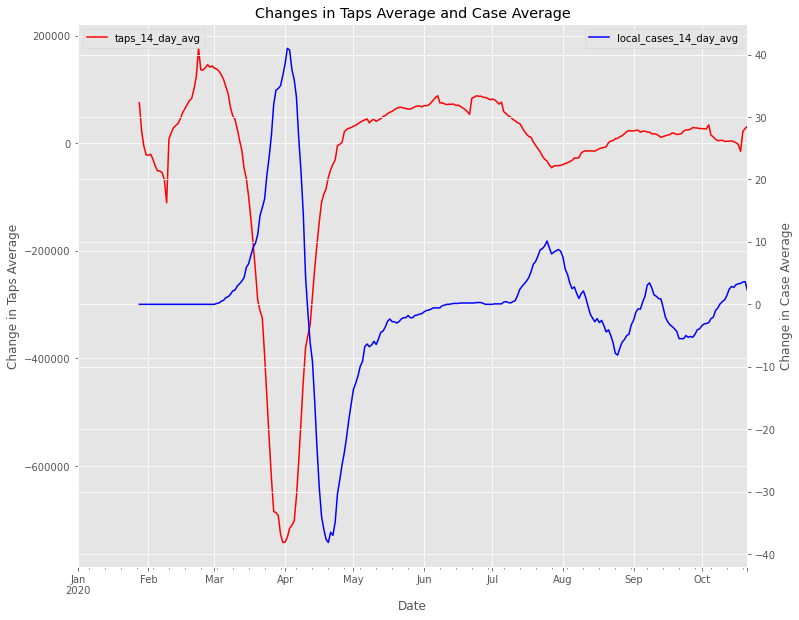

In [23]:
change_in_avg = reg_df.diff(periods=14)
fig, ax1 = plt.subplots()
ax2 = ax1.twinx()
change_in_avg.plot(y='taps_14_day_avg', ax=ax1, color='red')
change_in_avg.plot(y='local_cases_14_day_avg', ax=ax2, color='blue')
ax1.set_title('Changes in Taps Average and Case Average')
ax1.set_xlabel('Date')
ax1.set_ylabel('Change in Taps Average')
ax1.legend(loc=2)
ax2.set_ylabel('Change in Case Average')

In [24]:
change_in_avg.columns = ['diff_14_days_taps_avg', 'diff_14_days_local_cases_avg']
reg_df = reg_df.join(change_in_avg)

In [25]:
reg_df = reg_df.reindex(idx, fill_value=0)
reg_df.tail()

,taps_14_day_avg,local_cases_14_day_avg,diff_14_days_taps_avg,diff_14_days_local_cases_avg
2020-10-17,541885.714286,3.571429,-2264.285714,3.285714
2020-10-18,536178.571429,3.571429,-14953.571429,3.357143
2020-10-19,555807.142857,3.785714,21971.428571,3.571429
2020-10-20,560296.428571,3.857143,27642.857143,3.642857
2020-10-21,563971.428571,3.142857,31664.285714,2.214286


More differences will be added to the dataframe to capture immediate changes as well as longer term changes. This will hopefully capture information about the sentiment towards using public transport during the pandemic.

In [26]:
differences = [5, 7, 14, 21, 28]
for i in differences:
    change_in_case_avg = reg_df[['local_cases_14_day_avg']].diff(i)
    reg_df['diff_{}_days_local_cases_avg'.format(i)] = change_in_case_avg['local_cases_14_day_avg']

In [27]:
reg_df['taps_next_14_day_avg'] = reg_df['taps_14_day_avg'].shift(-1)
reg_df['local_cases_next_14_day_avg'] = reg_df['local_cases_14_day_avg'].shift(-1)
reg_df.dropna(inplace=True)

In [28]:
import math
reg_df_train = reg_df.iloc[:math.floor(reg_df.shape[0] * 0.8)]
reg_df_test = reg_df.iloc[math.floor(reg_df.shape[0] * 0.8):]

In [29]:
reg_df_train.head()

,taps_14_day_avg,local_cases_14_day_avg,diff_14_days_taps_avg,diff_14_days_local_cases_avg,diff_5_days_local_cases_avg,diff_7_days_local_cases_avg,diff_21_days_local_cases_avg,diff_28_days_local_cases_avg,taps_next_14_day_avg,local_cases_next_14_day_avg
2020-02-11,1.105332e+06,0.0,19471.428571,0.0,0.0,0.0,0.0,0.0,1.111700e+06,0.0
2020-02-12,1.111700e+06,0.0,28842.857143,0.0,0.0,0.0,0.0,0.0,1.117839e+06,0.0
2020-02-13,1.117839e+06,0.0,33085.714286,0.0,0.0,0.0,0.0,0.0,1.127686e+06,0.0
2020-02-14,1.127686e+06,0.0,37007.142857,0.0,0.0,0.0,0.0,0.0,1.135775e+06,0.0
2020-02-15,1.135775e+06,0.0,45692.857143,0.0,0.0,0.0,0.0,0.0,1.142571e+06,0.0


In [30]:
reg_df_test.head()

,taps_14_day_avg,local_cases_14_day_avg,diff_14_days_taps_avg,diff_14_days_local_cases_avg,diff_5_days_local_cases_avg,diff_7_days_local_cases_avg,diff_21_days_local_cases_avg,diff_28_days_local_cases_avg,taps_next_14_day_avg,local_cases_next_14_day_avg
2020-08-31,492910.714286,6.000000,22964.285714,-3.285714,1.214286,1.071429,-6.785714,-6.214286,493667.857143,6.642857
2020-09-01,493667.857143,6.642857,23210.714286,-2.571429,1.500000,2.285714,-5.857143,-5.142857,494807.142857,7.071429
2020-09-02,494807.142857,7.071429,23982.142857,-1.285714,1.857143,2.285714,-4.714286,-4.714286,496114.285714,7.142857
2020-09-03,496114.285714,7.142857,24453.571429,-0.714286,1.857143,2.000000,-4.071429,-5.142857,496017.857143,7.071429
2020-09-04,496017.857143,7.071429,20582.142857,-0.785714,1.785714,1.857143,-3.785714,-4.857143,498814.285714,7.285714


In [31]:
response_vars = ['taps_next_14_day_avg', 'local_cases_next_14_day_avg']
reg_df_train_X = reg_df_train.drop(response_vars, axis=1)
reg_df_train_y_taps = reg_df_train['taps_next_14_day_avg']
reg_df_train_y_cases = reg_df_train['local_cases_next_14_day_avg']
reg_df_test_X = reg_df_test.drop(response_vars, axis=1)
reg_df_test_y_taps = reg_df_test['taps_next_14_day_avg']
reg_df_test_y_cases = reg_df_test['local_cases_next_14_day_avg']

### Regression models

Two regression models are used for analysis - a linear regression and a multi-layer perceptron regressor. Both models will be fitted to the training data then tested on the training data for comparison. Transport usage and COVID cases in the future will be predicted for another comparison

In [32]:
taps_lin_model = LinearRegression()
taps_lin_model.fit(reg_df_train_X, reg_df_train_y_taps)

LinearRegression()

Text(0.5, 0, 'Date')

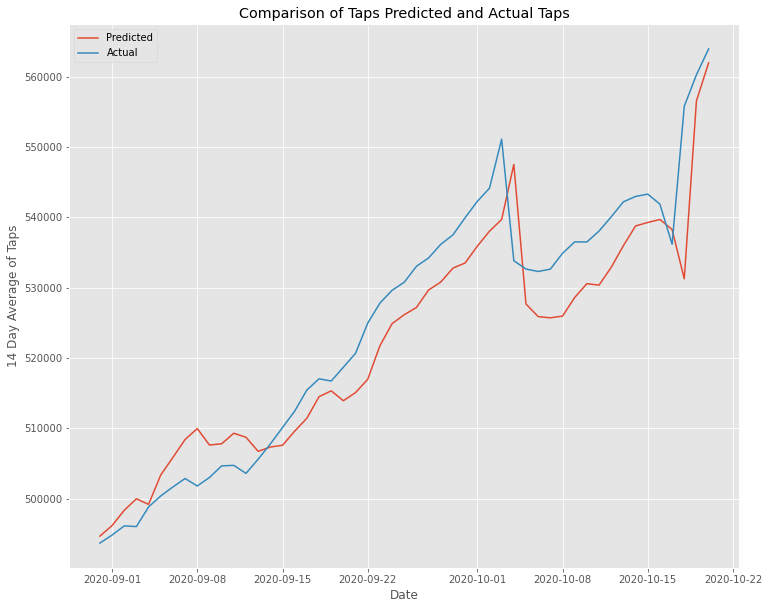

In [33]:
taps_lin_predicted = taps_lin_model.predict(reg_df_test_X)
plt.plot(reg_df_test.index, taps_lin_predicted)
plt.plot(reg_df_test_y_taps)
plt.legend(['Predicted', 'Actual'])
plt.title('Comparison of Taps Predicted and Actual Taps')
plt.ylabel('14 Day Average of Taps')
plt.xlabel('Date')

In [34]:
r2_score(reg_df_test_y_taps, taps_lin_predicted)

0.880525013065745

In [35]:
cases_lin_model = LinearRegression()
cases_lin_model.fit(reg_df_train_X, reg_df_train_y_cases)

LinearRegression()

Text(0.5, 0, 'Date')

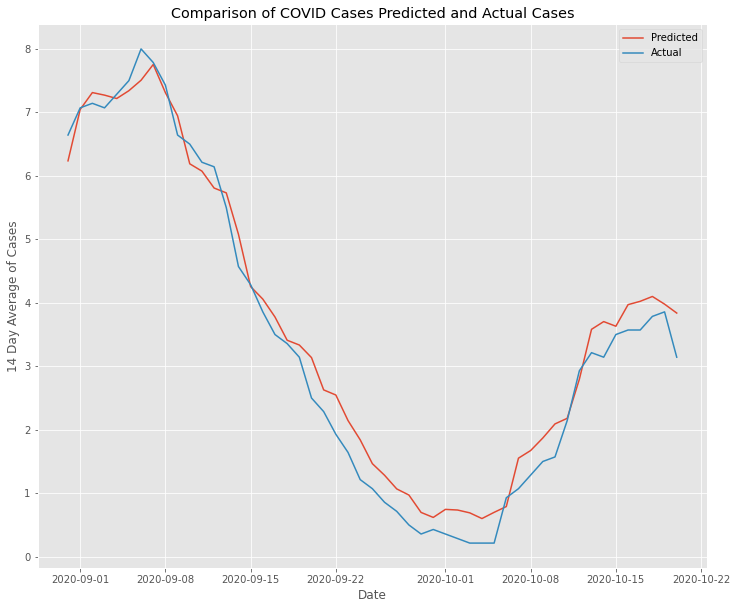

In [36]:
cases_lin_predicted = cases_lin_model.predict(reg_df_test_X)
plt.plot(reg_df_test.index, cases_lin_predicted)
plt.plot(reg_df_test_y_cases)
plt.legend(['Predicted', 'Actual'])
plt.title('Comparison of COVID Cases Predicted and Actual Cases')
plt.ylabel('14 Day Average of Cases')
plt.xlabel('Date')

In [37]:
r2_score(reg_df_test_y_cases, cases_lin_predicted)

0.9780318101833947

From the R2 scores, we see that the linear regression models are fairly accurate. However, we will see that this accuracy does not produce a reasonable prediction model for the future.

### Future forcasting of number of cases and public transport usage using the Linear Regression Models

The last rows of the dataframe will be used to predict the future and create new rows which will be used again to predict futher into the future.

In [38]:
future_lin_df = reg_df[-29:]
start_date = future_lin_df.index[0]
future_lin_df = future_lin_df.reset_index(drop=True)

In [39]:
future_lin_df.head()

,taps_14_day_avg,local_cases_14_day_avg,diff_14_days_taps_avg,diff_14_days_local_cases_avg,diff_5_days_local_cases_avg,diff_7_days_local_cases_avg,diff_21_days_local_cases_avg,diff_28_days_local_cases_avg,taps_next_14_day_avg,local_cases_next_14_day_avg
0,520667.857143,2.285714,17810.714286,-5.500000,-1.571429,-2.285714,-4.357143,-2.071429,524960.714286,1.928571
1,524960.714286,1.928571,23167.857143,-5.500000,-1.571429,-2.357143,-5.142857,-2.857143,527807.142857,1.642857
2,527807.142857,1.642857,24807.142857,-5.000000,-1.714286,-2.214286,-5.500000,-3.500000,529628.571429,1.214286
3,529628.571429,1.214286,24975.000000,-5.285714,-1.928571,-2.285714,-5.857143,-4.000000,530778.571429,1.071429
4,530778.571429,1.071429,26050.000000,-5.142857,-1.428571,-2.285714,-6.214286,-4.214286,533042.857143,0.857143


In [40]:
for i in range(28, 300):
    predictors = future_lin_df[i:i+1].drop(response_vars, axis=1)
    next_taps = taps_lin_model.predict(predictors)
    next_local_cases = cases_lin_model.predict(predictors)
    future_lin_df = future_lin_df.append({'taps_14_day_avg': next_taps[0],
                                  'local_cases_14_day_avg': next_local_cases[0],
                                  'diff_14_days_taps_avg': next_taps[0] - future_lin_df['taps_14_day_avg'].iloc[-14],
                                  'diff_14_days_local_cases_avg': next_local_cases[0] - future_lin_df['local_cases_14_day_avg'].iloc[-14],
                                  'diff_5_days_local_cases_avg': next_local_cases[0] - future_lin_df['local_cases_14_day_avg'].iloc[-5],
                                  'diff_7_days_local_cases_avg': next_local_cases[0] - future_lin_df['local_cases_14_day_avg'].iloc[-7],
                                  'diff_21_days_local_cases_avg': next_local_cases[0] - future_lin_df['local_cases_14_day_avg'].iloc[-21],
                                  'diff_28_days_local_cases_avg': next_local_cases[0] - future_lin_df['local_cases_14_day_avg'].iloc[-28],
                                 },
                                 ignore_index=True)

In [41]:
future_lin_df.index = pd.date_range(start_date, periods=301)

Text(0.5, 1.0, 'Future Transport Usage Based on a Linear Regression Model')

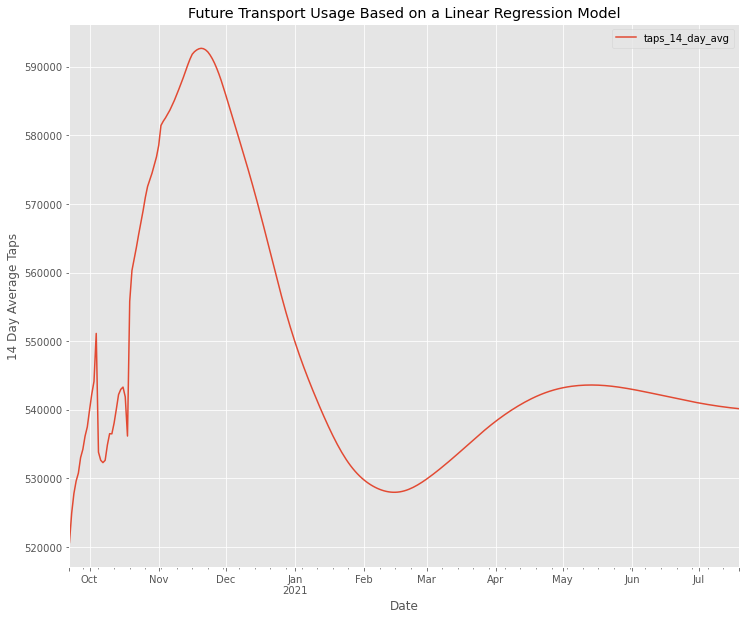

In [42]:
future_lin_df.plot(y='taps_14_day_avg')
plt.xlabel('Date')
plt.ylabel('14 Day Average Taps')
plt.title('Future Transport Usage Based on a Linear Regression Model')

Text(0.5, 1.0, 'Future Cases Reported Based on a Linear Regression Model')

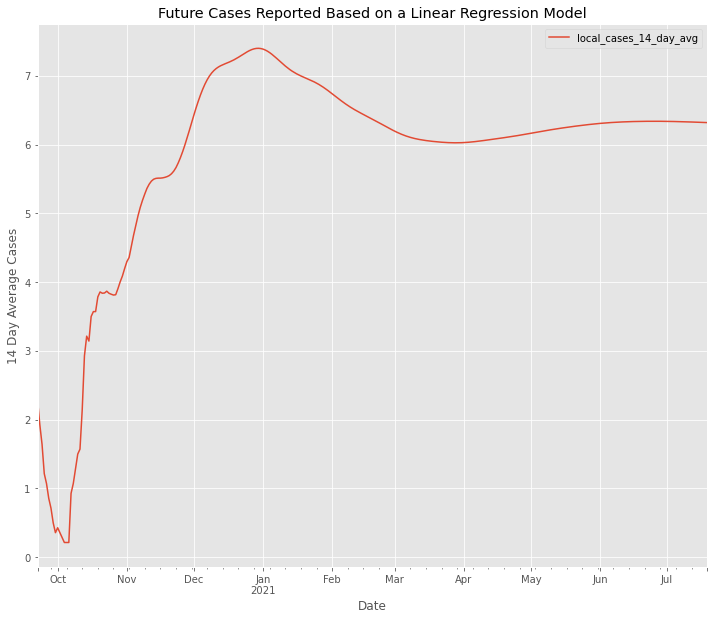

In [43]:
future_lin_df.plot(y='local_cases_14_day_avg')
plt.xlabel('Date')
plt.ylabel('14 Day Average Cases')
plt.title('Future Cases Reported Based on a Linear Regression Model')

We see from extending the prediction to the future, the 14 day average of taps stabilises but the local cases stabilises to a non-zero value. This could be due to not enough features for the model itself. The model assumes dependence on only taps and cases reported which does not reflect reality entirely.

### MLP Regressor models

Starting by analysing what is the most efficient amount of hidden elements needed for prediciting next day transport usage

In [44]:
cv_scores = []
cv_scores_std = []
hidden_unit_numbers = [[10],[20],[30],[40],[50],[60],[70],[80],[90],[100]]
for i in hidden_unit_numbers:
    clf_mlp = MLPRegressor(hidden_layer_sizes = i, random_state=42)
    clf_mlp.fit(reg_df_train_X, reg_df_train_y_taps)
    y_pred = clf_mlp.predict(reg_df_test_X)
    scores = r2_score(reg_df_test_y_taps, y_pred)
    cv_scores.append(scores.mean())
    cv_scores_std.append(scores.std())

The above block of code is used for iterating through the differing amounts of hidden layers and recording the R2 score each time which is recorded and later compared to one another to find the most effective amount of hidden layers for the model.

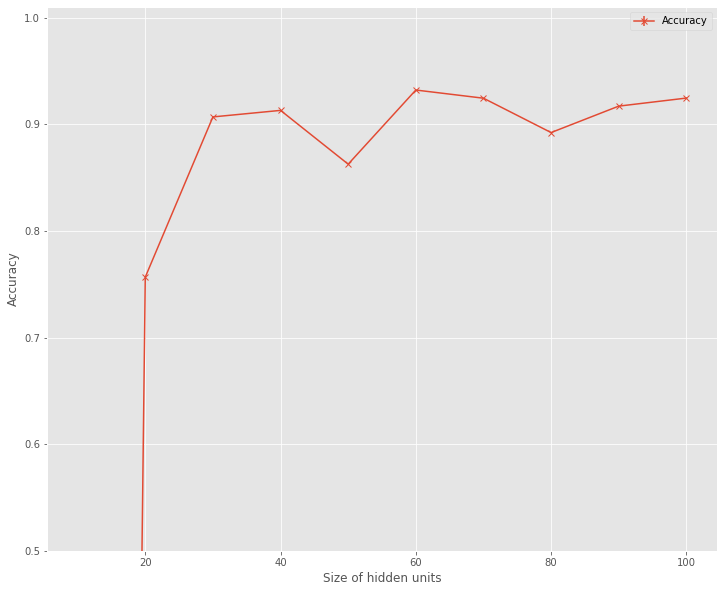

In [45]:
plt.errorbar(hidden_unit_numbers, cv_scores, yerr=cv_scores_std, marker='x', label='Accuracy')
plt.xlabel('Size of hidden units')
plt.ylim(0.5,1.01)
plt.ylabel('Accuracy')
plt.legend(loc='best')
plt.show()

The above graph shows that a model that has 30 or more hidden elements in it hidden layer will regualrly return a high accruacy for predicition. Overall it can be seen that a hidden layer elemenet count of 60 appears to be the most efficeint whcih is what will be used for the final model below. 

In [46]:
taps_mlp_model = MLPRegressor(max_iter=1000, random_state=42,hidden_layer_sizes=60)
taps_mlp_model.fit(reg_df_train_X, reg_df_train_y_taps)

MLPRegressor(hidden_layer_sizes=60, max_iter=1000, random_state=42)

Text(0.5, 0, 'Date')

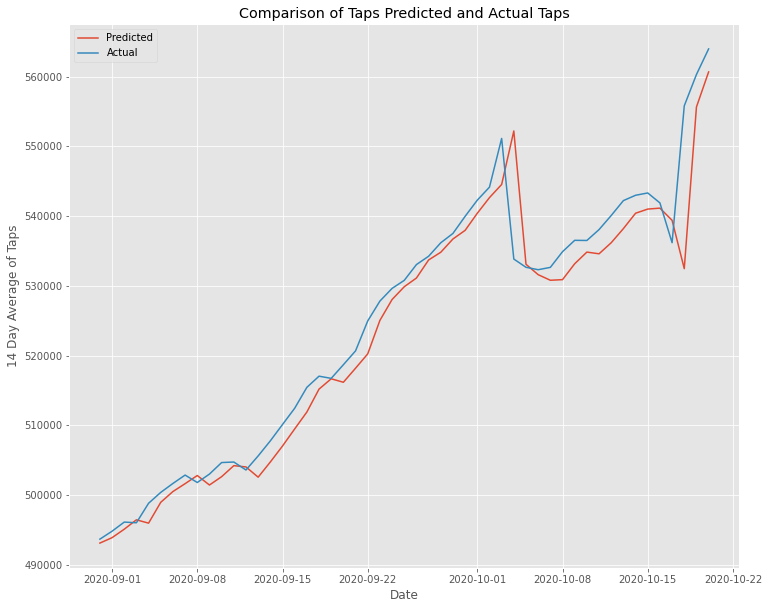

In [47]:
taps_mlp_predicted = taps_mlp_model.predict(reg_df_test_X)
plt.plot(reg_df_test.index, taps_mlp_predicted)
plt.plot(reg_df_test_y_taps)
plt.legend(['Predicted', 'Actual'])
plt.title('Comparison of Taps Predicted and Actual Taps')
plt.ylabel('14 Day Average of Taps')
plt.xlabel('Date')

In [48]:
r2_score(reg_df_test_y_taps, taps_mlp_predicted)

0.9322887798519647

As we can see, the final MLP Regressor model for predicitiong next tranportation usage in the metroploitan area has an r2 score of 0.932, which is slightly higher than the linear regession model's predicition score of 0.88

Below we develop a MLP Regressor model for predicting the next days number of reported cases throughout NSW. 

In [49]:
cv_scores = []
cv_scores_std = []
hidden_unit_numbers = [[1],[2],[3],[4],[5],[6],[7],[8],[9],[10]]
for i in hidden_unit_numbers:
    clf_mlp_cases = MLPRegressor(hidden_layer_sizes=i, solver='lbfgs',
                               activation='relu', max_iter=10000,
                               random_state=42)
    clf_mlp_cases.fit(reg_df_train_X, reg_df_train_y_cases)
    y_pred = clf_mlp_cases.predict(reg_df_test_X)
    scores = r2_score(reg_df_test_y_cases, y_pred)
    cv_scores.append(scores.mean())
    cv_scores_std.append(scores.std())

For this model, there was a lot of trial and error used to decide on which solver and activation should be used. The reason for going with the lbfgs was due to its reported efficiency with low amounts of data whilst the relu activation was found to be the most accruacte in comparison to the other options when testing. 

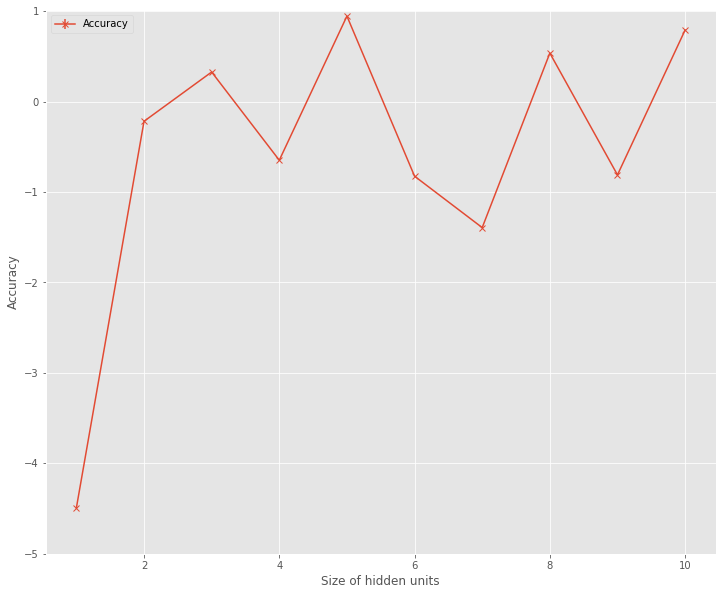

In [50]:
plt.errorbar(hidden_unit_numbers, cv_scores, yerr=cv_scores_std, marker='x', label='Accuracy')
plt.xlabel('Size of hidden units')
plt.ylim(-5,1.01)
plt.ylabel('Accuracy')
plt.legend(loc='best')
plt.show()

In comparison to the next day transport usage prediciton model, this model was much more efficient when using a much lower number of hidden elements as outlined in the above graph, where 5 hidden elements appeared to be the most effective. 

In [51]:
cases_mlp_model = MLPRegressor(hidden_layer_sizes=5, solver='lbfgs',
                               activation='relu', max_iter=10000,
                               random_state=42)
cases_mlp_model.fit(reg_df_train_X, reg_df_train_y_cases)

MLPRegressor(hidden_layer_sizes=5, max_iter=10000, random_state=42,
             solver='lbfgs')

Text(0.5, 0, 'Date')

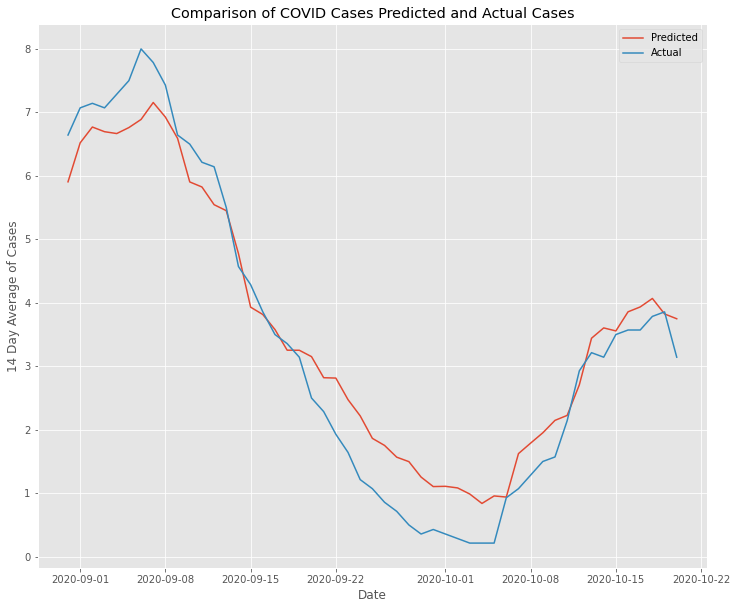

In [52]:
cases_mlp_predicted = cases_mlp_model.predict(reg_df_test_X)
plt.plot(reg_df_test.index, cases_mlp_predicted)
plt.plot(reg_df_test_y_cases)
plt.legend(['Predicted', 'Actual'])
plt.title('Comparison of COVID Cases Predicted and Actual Cases')
plt.ylabel('14 Day Average of Cases')
plt.xlabel('Date')

In [53]:
r2_score(reg_df_test_y_cases, cases_mlp_predicted)

0.944606427914391

As we can see witht ht efinal model we were able to get an r2 score of 0.944, which is slightly lower to the r2 score of 0.987 that was given by the linear regression model for predicting the next day number of cases. 

### Future forecasting of number of cases and public transport usage using the MLP Regressor models

In [54]:
future_mlp_df = reg_df[-29:]
start_date = future_mlp_df.index[0]
future_mlp_df = future_mlp_df.reset_index(drop=True)

In [55]:
future_mlp_df.head()

,taps_14_day_avg,local_cases_14_day_avg,diff_14_days_taps_avg,diff_14_days_local_cases_avg,diff_5_days_local_cases_avg,diff_7_days_local_cases_avg,diff_21_days_local_cases_avg,diff_28_days_local_cases_avg,taps_next_14_day_avg,local_cases_next_14_day_avg
0,520667.857143,2.285714,17810.714286,-5.500000,-1.571429,-2.285714,-4.357143,-2.071429,524960.714286,1.928571
1,524960.714286,1.928571,23167.857143,-5.500000,-1.571429,-2.357143,-5.142857,-2.857143,527807.142857,1.642857
2,527807.142857,1.642857,24807.142857,-5.000000,-1.714286,-2.214286,-5.500000,-3.500000,529628.571429,1.214286
3,529628.571429,1.214286,24975.000000,-5.285714,-1.928571,-2.285714,-5.857143,-4.000000,530778.571429,1.071429
4,530778.571429,1.071429,26050.000000,-5.142857,-1.428571,-2.285714,-6.214286,-4.214286,533042.857143,0.857143


In [56]:
for i in range(28, 300):
    predictors = future_mlp_df[i:i+1].drop(response_vars, axis=1)
    next_taps = taps_mlp_model.predict(predictors)
    next_local_cases = cases_mlp_model.predict(predictors)
    future_mlp_df = future_mlp_df.append({'taps_14_day_avg': next_taps[0],
                                  'local_cases_14_day_avg': next_local_cases[0],
                                  'diff_14_days_taps_avg': next_taps[0] - future_mlp_df['taps_14_day_avg'].iloc[-14],
                                  'diff_14_days_local_cases_avg': next_local_cases[0] - future_mlp_df['local_cases_14_day_avg'].iloc[-14],
                                  'diff_5_days_local_cases_avg': next_local_cases[0] - future_mlp_df['local_cases_14_day_avg'].iloc[-5],
                                  'diff_7_days_local_cases_avg': next_local_cases[0] - future_mlp_df['local_cases_14_day_avg'].iloc[-7],
                                  'diff_21_days_local_cases_avg': next_local_cases[0] - future_mlp_df['local_cases_14_day_avg'].iloc[-21],
                                  'diff_28_days_local_cases_avg': next_local_cases[0] - future_mlp_df['local_cases_14_day_avg'].iloc[-28],
                                 },
                                 ignore_index=True)

In [57]:
future_mlp_df.index = pd.date_range(start_date, periods=301)

Text(0.5, 1.0, 'Future Transport Usage Based on a MLP Regression Model')

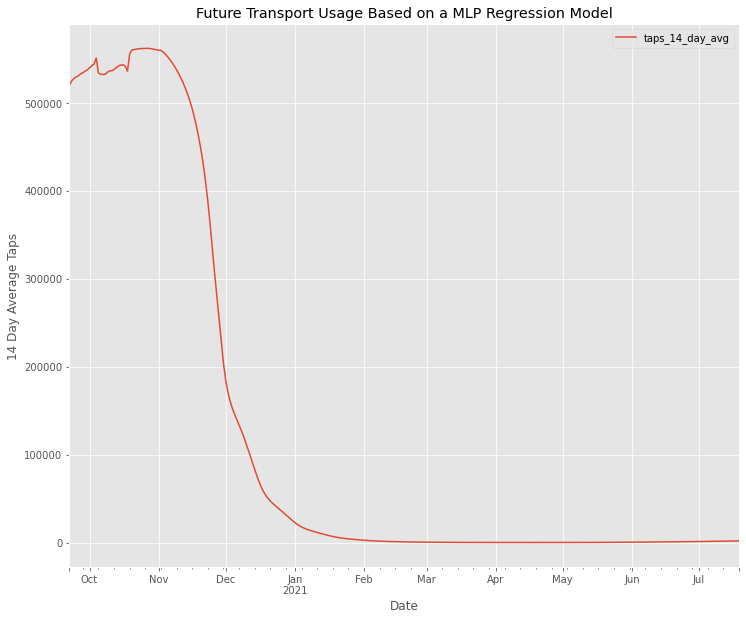

In [58]:
future_mlp_df.plot(y='taps_14_day_avg')
plt.xlabel('Date')
plt.ylabel('14 Day Average Taps')
plt.title('Future Transport Usage Based on a MLP Regression Model')

Text(0.5, 1.0, 'Future Cases Reported Based on a MLP Regression Model')

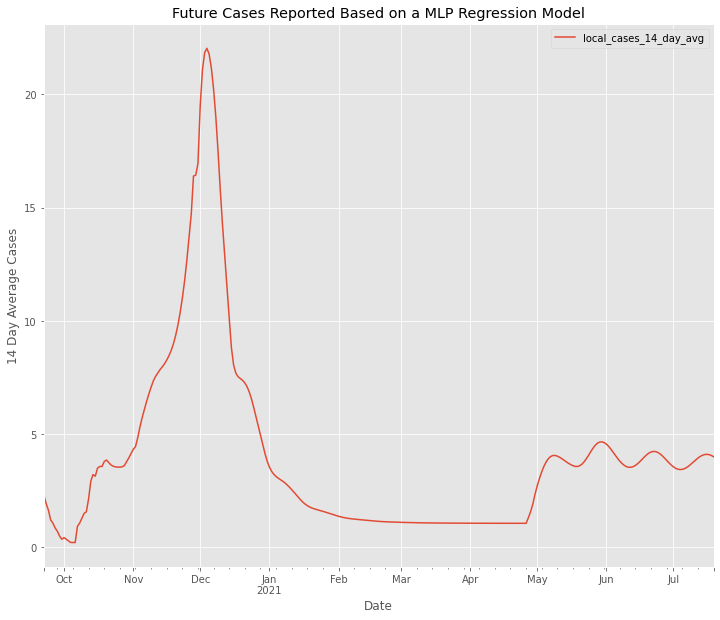

In [59]:
future_mlp_df.plot(y='local_cases_14_day_avg')
plt.xlabel('Date')
plt.ylabel('14 Day Average Cases')
plt.title('Future Cases Reported Based on a MLP Regression Model')

From both prediction models, the prediction of the future is not realistic. This is more evidence to suggest that the features used are not complete.